<img src = "https://images2.imgbox.com/c1/79/4H1V1tSO_o.png" width="1200">

# REGRESSÃO LOGÍSTICA E ALGORITMOS DE CLASSIFICAÇÃO
---

Para alguns tipos de problema nós não queremos fazer uma previsão dentro de um espaço contínuo como na Regressão Linear, mas sim fazer uma diferenciação entre opções, podendo ser **binário** (Sim ou Não, Aprovado ou Reprovado, etc.) ou **múltiplas categorias** (diferentes cores, classes, tipo de produto, etc.). Esses são os algoritmos de classificação.


E existem diversos algoritmos para realizar esse tipo de operação. Vamos começar pela Regressão Logística.

## Regressão logística
---

A regressão logística modela a probabilidade de um evento ocorrer de acordo com as variáveis independentes. Ela calcula a probabilidade (número entre 0 e 1) de que uma observação esteja em determinada categoria, através de uma função sigmoide (função matemática cujo nome vem da forma em S do seu gráfico).

Em termos visuais, é uma curva em formato de S:

<img src = "https://firebasestorage.googleapis.com/v0/b/images-tera-platform/o/public%2Fmedia%2F1632857999010-fig01.PNG?alt=media" width="900">

Vamos criar um dataset de exemplo para visualizarmos melhor.

Imagine que nós vamos montar um modelo de crédito baseado apenas no salário de pessoas.

In [1]:
import pandas as pd

credito = pd.DataFrame({'salario': [0.5, 0.8, 4.7, 3.7, 2.5, 1.1, 1.6, 2.7, 4.2, 4.8], 
                        'aprovado': [0, 0, 1, 1, 0, 0, 0, 1, 1, 1]})

Neste exemplo o campo salário representa os ganhos mensais em R$1.000. O campo "aprovado" é o que vamos prever: "0" representa os clientes que tiveram o crédito reprovado e "1" aqueles que tiveram o crédito aprovado.

Vamos olhar essas informações no gráfico:

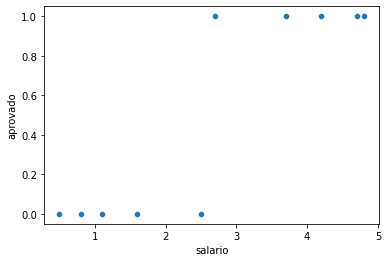

In [2]:
import seaborn as sns

sns.scatterplot(x=credito['salario'], y=credito['aprovado']);

Agora vamos usar a regressão logística para calcular a probabilidade de aprovação de crédito dado o salário de um novo cliente.

In [3]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(credito[['salario']], credito['aprovado'])

Colocando no gráfico:

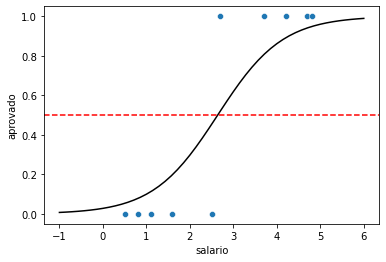

In [4]:
import numpy as np

X = np.linspace(-1, 6)
proba = lr.predict_proba(X.reshape(-1, 1)).T[1]

chart = sns.scatterplot(x=credito['salario'], y=credito['aprovado'])
sns.lineplot(x=X, y=proba, color='black')
chart.axhline(0.5, ls='--', color='red');

No gráfico acima podemos ver a curva de probabilidade em preto, tendo nosso ‘Treshold’, ou fronteira de decisão, em 0.5, representado pela linha vermelha. Todos que estiverem com a probabilidade 0.5 ou maior serão classificados como 1 (terão o crédito aprovado) e todos que estiverem abaixo serão classificado como 0 (será reprovado).

Esse ‘Threshold’ também é um parâmetro que podemos alterar de acordo com nossas decisões de negócio.

## Aplicando em um dataset maior
---

Agora vamos aplicar esse novo conhecimento em um dataset um pouco maior e não inventado. Usaremos o dataset: Breast Cancer Wisconsin (Diagnostic), disponibilizado pelo Scikit-learn. A variável alvo classifica como 1 o tumor maligno e 0 o Benigno. As demais variáveis são calculadas a partir de uma imagem digitalizada de uma massa mamária. Eles descrevem características dos núcleos celulares presentes na imagem.

In [5]:
#Carregando o Dataset
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
variaveis = pd.DataFrame(dataset.data, columns=dataset.feature_names)

target = pd.Series(dataset.target, name='diagnostico')

df = pd.concat([variaveis, target], axis=1)

## EDA Básico
---

Faremos um rápido EDA somente com algumas variáveis para que a gente possa focar nos algoritmos de classificação. Olhando o diagnóstico contra as outras variáveis, tentamos descobrir quais nos trazem mais informação para diferenciar o "tumor maligno do benigno", isto é, em quais variáveis eu enxergo uma distribuição em que elas sejam mais distantes.

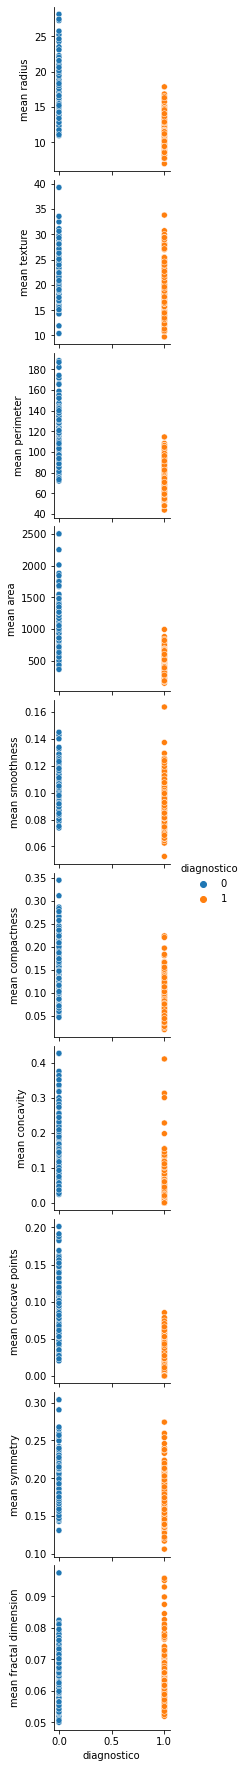

In [6]:
sns.pairplot(df, x_vars=['diagnostico'], y_vars=['mean radius', 'mean texture', 
                                                 'mean perimeter', 'mean area', 'mean smoothness',
                                                 'mean compactness', 'mean concavity', 'mean concave points', 
                                                 'mean symmetry', 'mean fractal dimension'], hue='diagnostico');

É sempre interessante também procurar por multicolinearidade, ou seja, um problema comum em regressões, no qual as variáveis independentes possuem relações lineares exatas ou aproximadamente exatas, nas variáveis independentes. Caso encontremos variáveis que tenham uma alta correlação, devemos optar por incluir apenas uma delas.

Observe a tabela gerada abaixo:

In [7]:
df[['diagnostico', 'mean radius', 'mean texture', 'mean perimeter', 'mean area', 
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean compactness', 'mean concavity', 'mean concave points', 
    'mean symmetry', 'mean fractal dimension']].corr()

,diagnostico,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
diagnostico,1.000000,-0.730029,-0.415185,-0.742636,-0.708984,-0.358560,-0.596534,-0.696360,-0.596534,-0.696360,-0.776614,-0.330499,0.012838
mean radius,-0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.506124,0.676764,0.822529,0.147741,-0.311631
mean texture,-0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.236702,0.302418,0.293464,0.071401,-0.076437
mean perimeter,-0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.556936,0.716136,0.850977,0.183027,-0.261477
mean area,-0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.498502,0.685983,0.823269,0.151293,-0.283110
mean smoothness,-0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.659123,0.521984,0.553695,0.557775,0.584792
mean compactness,-0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,1.000000,0.883121,0.831135,0.602641,0.565369
mean concavity,-0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.883121,1.000000,0.921391,0.500667,0.336783
mean compactness,-0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,1.000000,0.883121,0.831135,0.602641,0.565369
mean concavity,-0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.883121,1.000000,0.921391,0.500667,0.336783


Podemos ver que "mean radius", **"mean perimeter"** e **"mean area"** tem uma correlação quase próxima a 1. Então devemos optar pela inclusão de apenas uma delas na regressão.

## Train/test split
---

Abaixo, vamos dividir o dataset em Treino e Teste e em seguida treinar o modelo.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(variaveis[['mean radius', 'mean texture', 'mean symmetry']], target, test_size=0.25, random_state=101)

Esse comando vai dividir o dataset em treino e teste, separando as variáveis independentes da nossa variável alvo.

'test_size': indica o percentual do dataset que será separado para teste, no caso 25%.

'random_state': indica como a divisão é feita de maneira aleatória —um jeito de garantir que se você quiser ter o mesmo resultado que o meu, basta passar o mesmo número que coloquei neste hiperparâmetro.

Pronto! Agora para toda a regressão logística e para fazer a previsão nos dados de teste basta rodar o seguinte código:

In [9]:
lr = LogisticRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

## Métricas
---

In [10]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_score, plot_roc_curve

### Avaliando o modelo de classificação

Com o nosso modelo treinado, precisamos entender qual a performance quando ele está olhando para novos dados. Por isso fizemos a divisão em treino e teste.

## Matriz de confusão
---

Na tabela abaixo temos a Matriz de confusão. Essa matriz traz a frequência para cada classificação cruzando a previsão que o modelo gerou com o diagnóstico real.

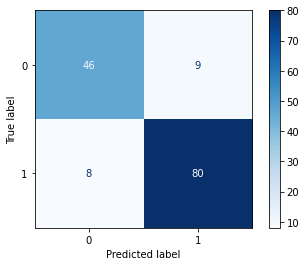

In [11]:
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues');

Nessa tabela podemos ver que seis casos de diagnóstico Maligno o modelo previu como Benigno e nove casos onde o diagnóstico real era Benigno e o modelo classificou incorretamente como Maligno.

Nessa tabela podemos ver que seis casos de diagnóstico Maligno o modelo previu como Benigno e nove casos onde o diagnóstico real era Benigno e o modelo classificou incorretamente como Maligno.

- Acurácia: % de predições corretas

- Precisão: % de predições corretas dentro da classe positiva

- Recall: % de predições corretas dentro da classe esperada como positiva

Com o comando abaixo podemos ver todas essas métricas:

In [12]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_lr)}\n\
Precisão: {precision_score(y_test, y_pred_lr)}\n\
Recall: {recall_score(y_test, y_pred_lr)}')

Acurácia: 0.8811188811188811
Precisão: 0.898876404494382
Recall: 0.9090909090909091


## Curva ROC e AUC
---

A Curva ROC (Receiver Operating Characteristic ou Característica de Operação do Receptor) é uma representação gráfica que ilustra o desempenho de um sistema classificador binário à medida que o seu limiar de discriminação varia. É criada quando colocamos no gráfico a taxa de verdadeiro-positivo contra a taxa de falso-positivo para diferentes ''thresholds".

Lembra lá no começo desse artigo, aquela linha vermelha que decidimos colocar em 0.5? Variando esse valor de 0 a 1 e vendo como a taxa de verdadeiro-positivo e falso-positivo mudam, temos a curva ROC. E, para transformar essa curva em um número temos a AUC (Area under the curve ou a Área sob a curva, em tradução livre, que representa grau ou medida de separabilidade), dessa maneira fica mais fácil de comparar essa métrica entre diversos modelos.

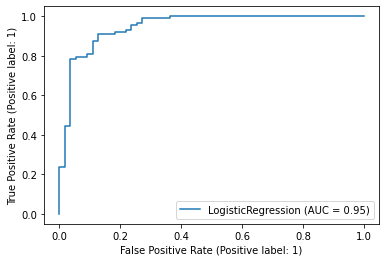

In [13]:
plot_roc_curve(lr, X_test, y_test);

## Outros algoritmos de classificação
---

A seguir veremos de maneira breve outros algoritmos de classificação. Como passaremos rapidamente por eles, deixarei o link da documentação de cada um. Assim você pode explorar cada um com mais atenção e brincar com os hiperparâmetros para ver como a performance se altera.

A estrutura será a seguinte:

- Carregar o modelo

- Treinar o modelo

- Prever com a partição de teste do dataset

- Calcular as métricas

## SVM
---

<img src = "https://firebasestorage.googleapis.com/v0/b/images-tera-platform/o/public%2Fmedia%2F1632867045559-fig11.PNG?alt=media" width="900">

In [14]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

## Matriz de confusão
---

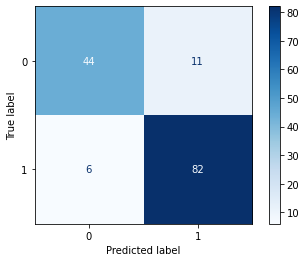

In [15]:
plot_confusion_matrix(svm, X_test, y_test, cmap='Blues');

## Métricas
---

In [16]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_svm)}\n\
Precisão: {precision_score(y_test, y_pred_svm)}\n\
Recall: {recall_score(y_test, y_pred_svm)}')

Acurácia: 0.8811188811188811
Precisão: 0.8817204301075269
Recall: 0.9318181818181818


## Curva ROC
---

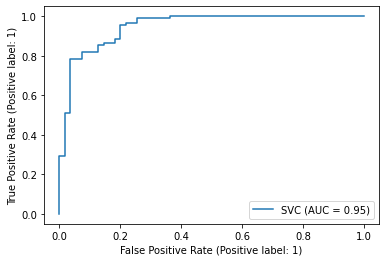

In [17]:
plot_roc_curve(svm, X_test, y_test);

## KNN
---

Cada observação será classificada de acordo com os seus vizinhos. Se k for igual a 3, a nova observação será comparada com os 3 vizinhos mais próximos e a classe a que pertencer a maioria desses vizinhos será atribuída à nova observação.

<img src = "https://firebasestorage.googleapis.com/v0/b/images-tera-platform/o/public%2Fmedia%2F1632867674965-fig14.PNG?alt=media" width="900">

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

## Matriz de Confusão
---

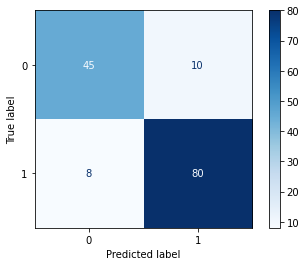

In [19]:
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues');

## Métricas
---

In [20]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_knn)}\n\
Precisão: {precision_score(y_test, y_pred_knn)}\n\
Recall: {recall_score(y_test, y_pred_knn)}')

Acurácia: 0.8741258741258742
Precisão: 0.8888888888888888
Recall: 0.9090909090909091


## Curva ROC
---

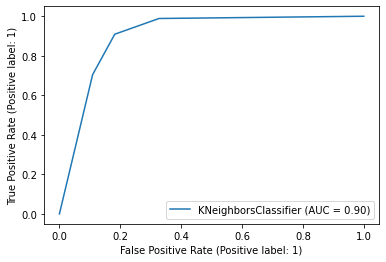

In [21]:
plot_roc_curve(knn, X_test, y_test);

## Naive Bayes
---

É um classificador probabilístico com base na aplicação do teorema de Bayes com a suposição “ingênua” de independência condicional entre cada variável.

In [22]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

## Matriz de Confusão
---

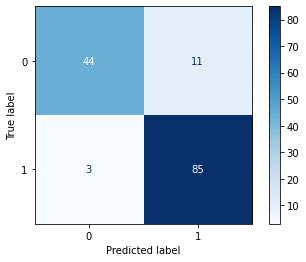

In [23]:
plot_confusion_matrix(nb, X_test, y_test, cmap='Blues');

## Métricas
---

In [24]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_nb)}\n\
Precisão: {precision_score(y_test, y_pred_nb)}\n\
Recall: {recall_score(y_test, y_pred_nb)}')

Acurácia: 0.9020979020979021
Precisão: 0.8854166666666666
Recall: 0.9659090909090909


## Curva ROC
---

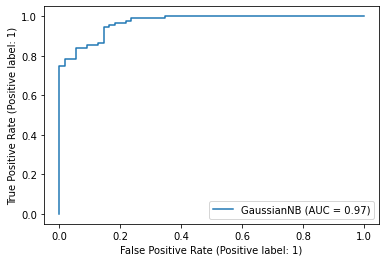

In [25]:
plot_roc_curve(nb, X_test, y_test);

## Árvore de Decisão
---

Uma árvore de decisão é uma representação de uma tabela de decisão sob a forma de uma árvore, porém pode haver outras aplicações. Tem a mesma utilidade da tabela de decisão.

Esse modelo irá classificar novas observações através de simples regras de decisão que terá aprendido com o dataset de treino. Uma característica bem legal desse método é que podemos visualizar a regra de cada nó.

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)
y_pred_dtree = nb.predict(X_test)

## Matriz de Confusão
---

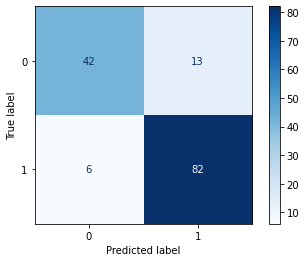

In [27]:
plot_confusion_matrix(dtree, X_test, y_test, cmap='Blues');

## Métricas
---

In [28]:
print(f'Acurácia: {accuracy_score(y_test, y_pred_dtree)}\n\
Precisão: {precision_score(y_test, y_pred_dtree)}\n\
Recall: {recall_score(y_test, y_pred_dtree)}')

Acurácia: 0.9020979020979021
Precisão: 0.8854166666666666
Recall: 0.9659090909090909


## Curva ROC
---

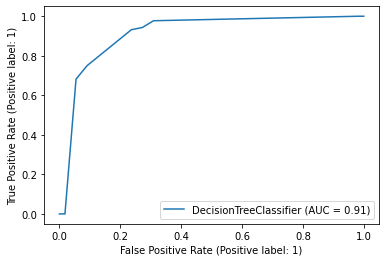

In [29]:
plot_roc_curve(dtree, X_test, y_test);

[Text(558.0, 475.65000000000003, 'mean radius <= 15.045\ngini = 0.465\nsamples = 426\nvalue = [157, 269]\nclass = Maligno'),
 Text(279.0, 339.75, 'mean symmetry <= 0.202\ngini = 0.217\nsamples = 298\nvalue = [37, 261]\nclass = Maligno'),
 Text(139.5, 203.85000000000002, 'mean texture <= 19.605\ngini = 0.133\nsamples = 251\nvalue = [18, 233]\nclass = Maligno'),
 Text(69.75, 67.94999999999999, 'gini = 0.035\nsamples = 169\nvalue = [3, 166]\nclass = Maligno'),
 Text(209.25, 67.94999999999999, 'gini = 0.299\nsamples = 82\nvalue = [15, 67]\nclass = Maligno'),
 Text(418.5, 203.85000000000002, 'mean radius <= 12.335\ngini = 0.482\nsamples = 47\nvalue = [19, 28]\nclass = Maligno'),
 Text(348.75, 67.94999999999999, 'gini = 0.153\nsamples = 24\nvalue = [2, 22]\nclass = Maligno'),
 Text(488.25, 67.94999999999999, 'gini = 0.386\nsamples = 23\nvalue = [17, 6]\nclass = Benigno'),
 Text(837.0, 339.75, 'mean texture <= 14.955\ngini = 0.117\nsamples = 128\nvalue = [120, 8]\nclass = Benigno'),
 Text(697

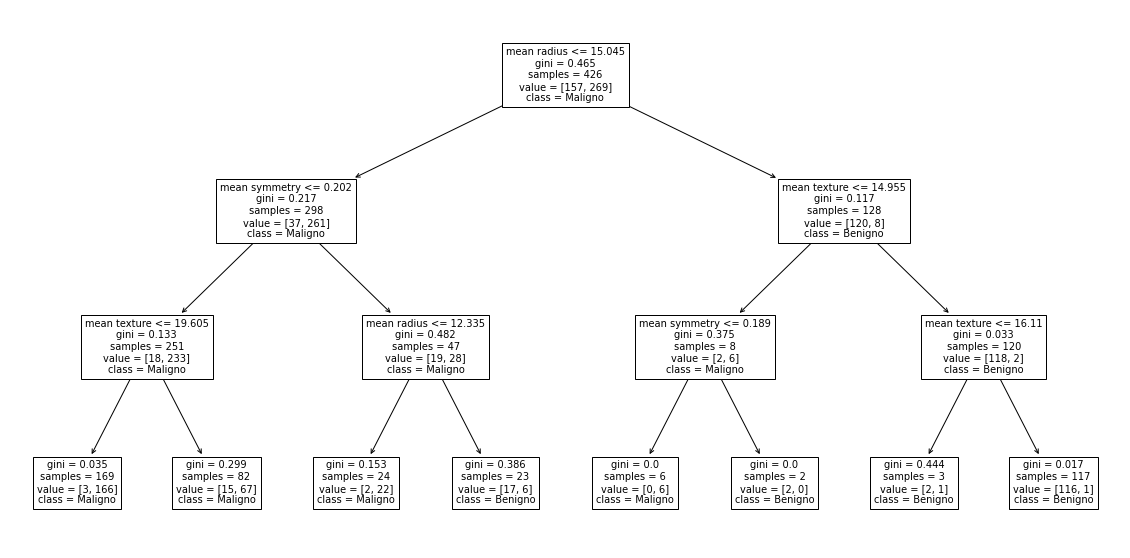

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dtree, feature_names=['mean radius', 'mean texture', 'mean symmetry'], class_names=['Benigno', 'Maligno'])

## Comparando todos os modelos
---

Agora que vimos os principais modelos de classificação segue abaixo um exemplo de como podemos fazer a comparação de todos eles com as métricas que aprendemos

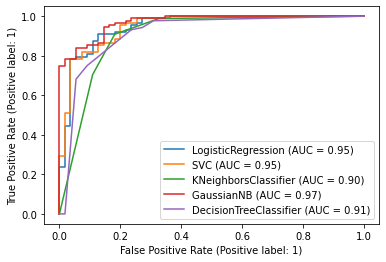

In [31]:
classifiers = [lr, svm, knn, nb, dtree]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

Caso seja confuso olhar todos os modelos juntos, pode-se comparar apenas a AUC ou diminuir a quantidade de modelos que estão listados.

Veja o mesmo gráfico mas com apenas 3 dos 5 modelos que vimos neste artigo:

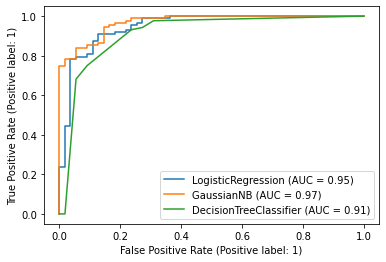

In [32]:
classifiers = [lr, nb, dtree]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [35]:
for i in classifiers:
    y_pred = i.predict(X_test)
    print(f'**{type(i).__name__}**')
    print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}\nPrecisão: {round(precision_score(y_test, y_pred), 2)}\nRecall: {round(recall_score(y_test, y_pred), 2)}')
    print('__________________')

**LogisticRegression**
Acurácia: 0.88
Precisão: 0.9
Recall: 0.91
__________________
**GaussianNB**
Acurácia: 0.9
Precisão: 0.89
Recall: 0.97
__________________
**DecisionTreeClassifier**
Acurácia: 0.87
Precisão: 0.86
Recall: 0.93
__________________


## Referências:

Documentação dos modelos que vimos:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

---